In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catalog import EarthquakeCatalog, Catalog

from sklearn.neighbors import BallTree

import torch
import pytorch_lightning as pl
import eq

(<GeoAxesSubplot: xlabel='Longitude', ylabel='Latitude'>,
 <AxesSubplot: xlabel='mag'>,
 <AxesSubplot: xlabel='Time', ylabel='mag'>)

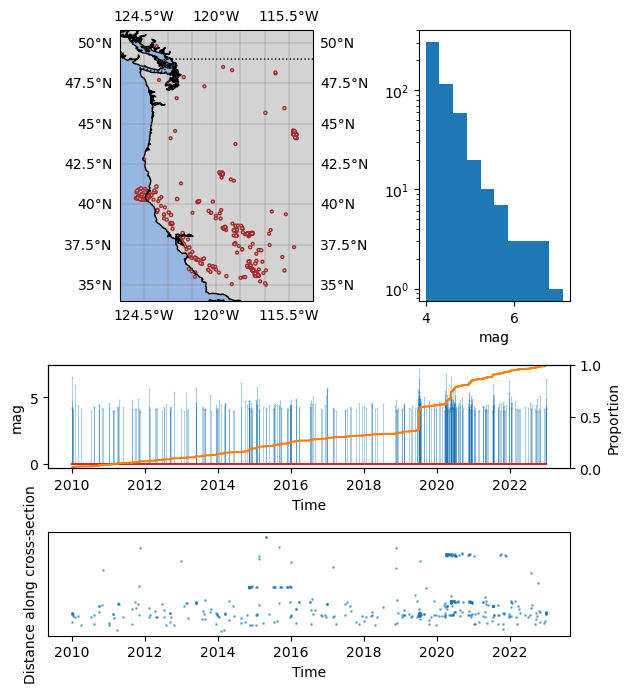

In [2]:
# Read in the data
mag_completeness = 4.0

earthquakes = EarthquakeCatalog(
    filename="data/earthquakes.csv",
    kwargs={
    "starttime": "2010-01-01",
    "endtime": "2023-01-01",
    "latitude_range": [35, 50],
    "longitude_range": [-125, -115],
    "minimum_magnitude":mag_completeness,
    }
)

earthquakes.plot_summary()

In [3]:
earthquakes.catalog.head()

,EVENT_ID,time,lat,lon,dep,mag
525,2842774,2010-01-04 14:24:51.730000128,40.2743,-123.8909,12900.0,4.3
524,2842899,2010-01-07 18:09:34.910000128,37.3802,-121.9062,10000.0,4.2
523,2842975,2010-01-10 00:27:41.850000128,40.6654,-124.4669,20600.0,6.5
522,2842987,2010-01-10 02:21:40.119999744,40.6254,-124.6176,19400.0,4.7
521,2842991,2010-01-10 03:07:02.589999616,40.6334,-124.5807,23500.0,4.1


#### ETAS stochastic declustering
 
The ETAS stochastic declustering method is a more sophisticated approach. It relies on the Epidemic Type Aftershocks Sequence Model (ETAS) to model the temporal evolution of seismicity. The model represent the intensity of aftershocks as the sum of a background seismicity rate and the aftershock sequence of preceeding earthquake:

$$ \lambda = \mu + \sum(\phi(t-t_i)) $$

where $\mu$ is the background seismicity rate, $\phi(t)$ is the aftershock sequence, and $t_i$ is the time of an earthquake.

The an earthquake is said to be part of the background process with a probability: $P_{\rm bg} = \frac{\mu}{\lambda}$. A thinning procedure is then used to randomly remove earthquakes with a probability of $1/P_{\rm bg}$.

For this demo, I will use the pytorch ETAS implementation from the Dascher-Cousineau et al. (in review).

In [5]:
t_start = 0
t_end = earthquakes.duration/np.timedelta64(1, 'D')

inter_times = np.diff(
    ((earthquakes.catalog.time - earthquakes.start_time)/np.timedelta64(1, 'D')).values,
    prepend=t_start,
    append=t_end
)

seq = eq.data.Sequence(
    inter_times = torch.as_tensor(inter_times, dtype=torch.float32),
    t_start=t_start,
    t_nll_start=t_end/5, # 20% of the data is used to burn in the model but does not contribute to the loss
    t_end=t_end,
    mag=torch.as_tensor(earthquakes.catalog.mag.values, dtype=torch.float32),
)
dataset = eq.data.InMemoryDataset(sequences=[seq])
dl = dataset.get_dataloader()

model = eq.models.ETAS(
    mag_completeness=mag_completeness,
    base_rate_init=len(earthquakes)/t_end,
)
trainer = pl.Trainer(max_epochs=500, devices=1, accelerator='mps')
trainer.fit(model, dl)

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/eq-0.0.1-py3.10.egg/eq/data/sequence.py:153: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard suppo

Training: 0it [00:00, ?it/s]

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/eq-0.0.1-py3.10.egg/eq/models/etas.py:548: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  selected_rows.append(matrix_row.masked_select(mask_row))
`Trainer.fit` stopped: `max_epochs=500` reached.


In [6]:
mu, k, c, p, alpha = [getattr(model,param).item() for param in ["mu", "k", "c", "p", "alpha"]]
print(f"mu={mu:.2f}, k={k:.2f}, c={c:.3f}, p={p:.2f}, alpha={alpha:.1f}")

mu=0.04, k=0.01, c=0.002, p=1.06, alpha=0.9


In [7]:
mu, k, c, p, alpha = [getattr(model,param).item() for param in ["mu", "k", "c", "p", "alpha"]]

etas_rate = lambda t, ti, mi: mu + np.sum(k*10**(alpha*(mi-mag_completeness))/(t-ti+c)**p)
rate = np.array(
    [
        etas_rate(
            t, 
            seq.arrival_times[seq.arrival_times<t].detach().numpy(),
            seq.mag[seq.arrival_times<t].detach().numpy()
        ) 
        for t in seq.arrival_times.detach().numpy()
    ]
)
background_probability = model.mu.item()/rate

<AxesSubplot: xlabel='Time', ylabel='mag'>

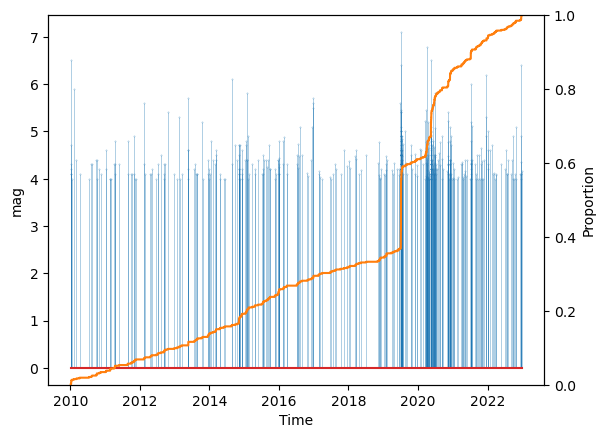

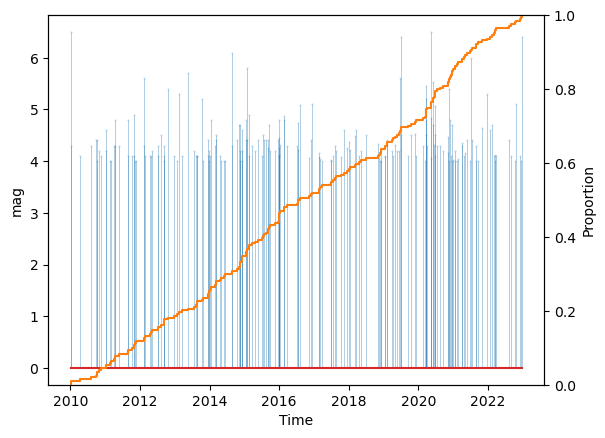

In [8]:
thinned_bool = [True if np.random.rand() < p else False for p in background_probability]
thinned_earthquakes = Catalog(earthquakes[thinned_bool])

earthquakes.plot_time_series()
thinned_earthquakes.plot_time_series()